In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import getpass
from __future__ import annotations

from typing import Any
import numpy as np
import folium

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

e:\SAMS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: tuple[float, float] | None = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [3]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

# Your client credentials
client_id = 'sh-dc470478-1d88-4abf-928f-1270585855a2'
client_secret = '3SR5S3Mas5MkJYx7qfRlSsUUsTEiug8Q'

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://sh.dataspace.copernicus.eu/configuration/v1/wms/instances")
print(resp.content)

b'[]'


In [20]:
config = SHConfig()
config.sh_client_id = 'sh-dc470478-1d88-4abf-928f-1270585855a2'
config.sh_client_secret = '3SR5S3Mas5MkJYx7qfRlSsUUsTEiug8Q'
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

In [21]:
aoi_coords_wgs84 = [-111.6580002, 48.9083015, -111.7580002, 49.0083015]

In [22]:
resolution = 5
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Image shape at 5 m resolution: (1485, 2210) pixels


In [23]:
catalog = SentinelHubCatalog(config=config)

In [24]:
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
time_interval = "2024-11-23", "2024-12-03"

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=aoi_bbox,
    time=time_interval,
    fields={"include": ["id", "properties.datetime"], "exclude": []},
)


In [25]:

results = list(search_iterator)
print("Total number of results:", len(results))

results

Total number of results: 5


[{'id': 'S2A_MSIL2A_20241203T183741_N0511_R027_T12UVV_20241203T221112.SAFE',
  'properties': {'datetime': '2024-12-03T18:40:36.724Z'}},
 {'id': 'S2A_MSIL2A_20241130T182731_N0511_R127_T12UVV_20241130T214609.SAFE',
  'properties': {'datetime': '2024-11-30T18:30:38.872Z'}},
 {'id': 'S2B_MSIL2A_20241128T183639_N0511_R027_T12UVV_20241128T202900.SAFE',
  'properties': {'datetime': '2024-11-28T18:40:37.809Z'}},
 {'id': 'S2B_MSIL2A_20241125T182619_N0511_R127_T12UVV_20241125T204149.SAFE',
  'properties': {'datetime': '2024-11-25T18:30:40.831Z'}},
 {'id': 'S2A_MSIL2A_20241123T183711_N0511_R027_T12UVV_20241123T220050.SAFE',
  'properties': {'datetime': '2024-11-23T18:40:35.144Z'}}]

In [31]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2023-11-23", "2023-12-03"),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

In [32]:
true_color_imgs = request_true_color.get_data()

In [ ]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (2210, 1485, 3)


Image type: uint8


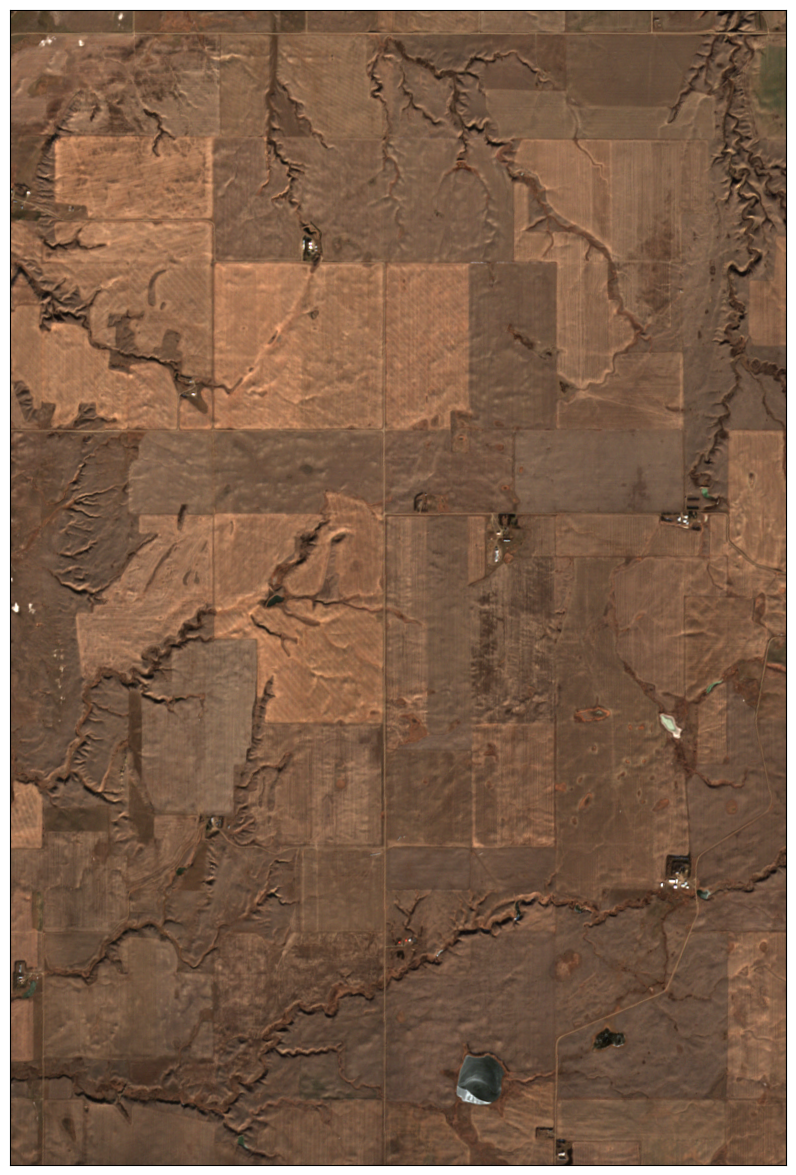

In [34]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

In [16]:
image

In [80]:
farm_map = folium.Map(location=[(aoi_coords_wgs84[1] + aoi_coords_wgs84[3]) / 2, (aoi_coords_wgs84[0] + aoi_coords_wgs84[2]) / 2], zoom_start=15)
folium.raster_layers.ImageOverlay(
    image=image,
    bounds=[[aoi_coords_wgs84[1], aoi_coords_wgs84[0]], [aoi_coords_wgs84[3], aoi_coords_wgs84[2]]],
    opacity=1,
).add_to(farm_map)


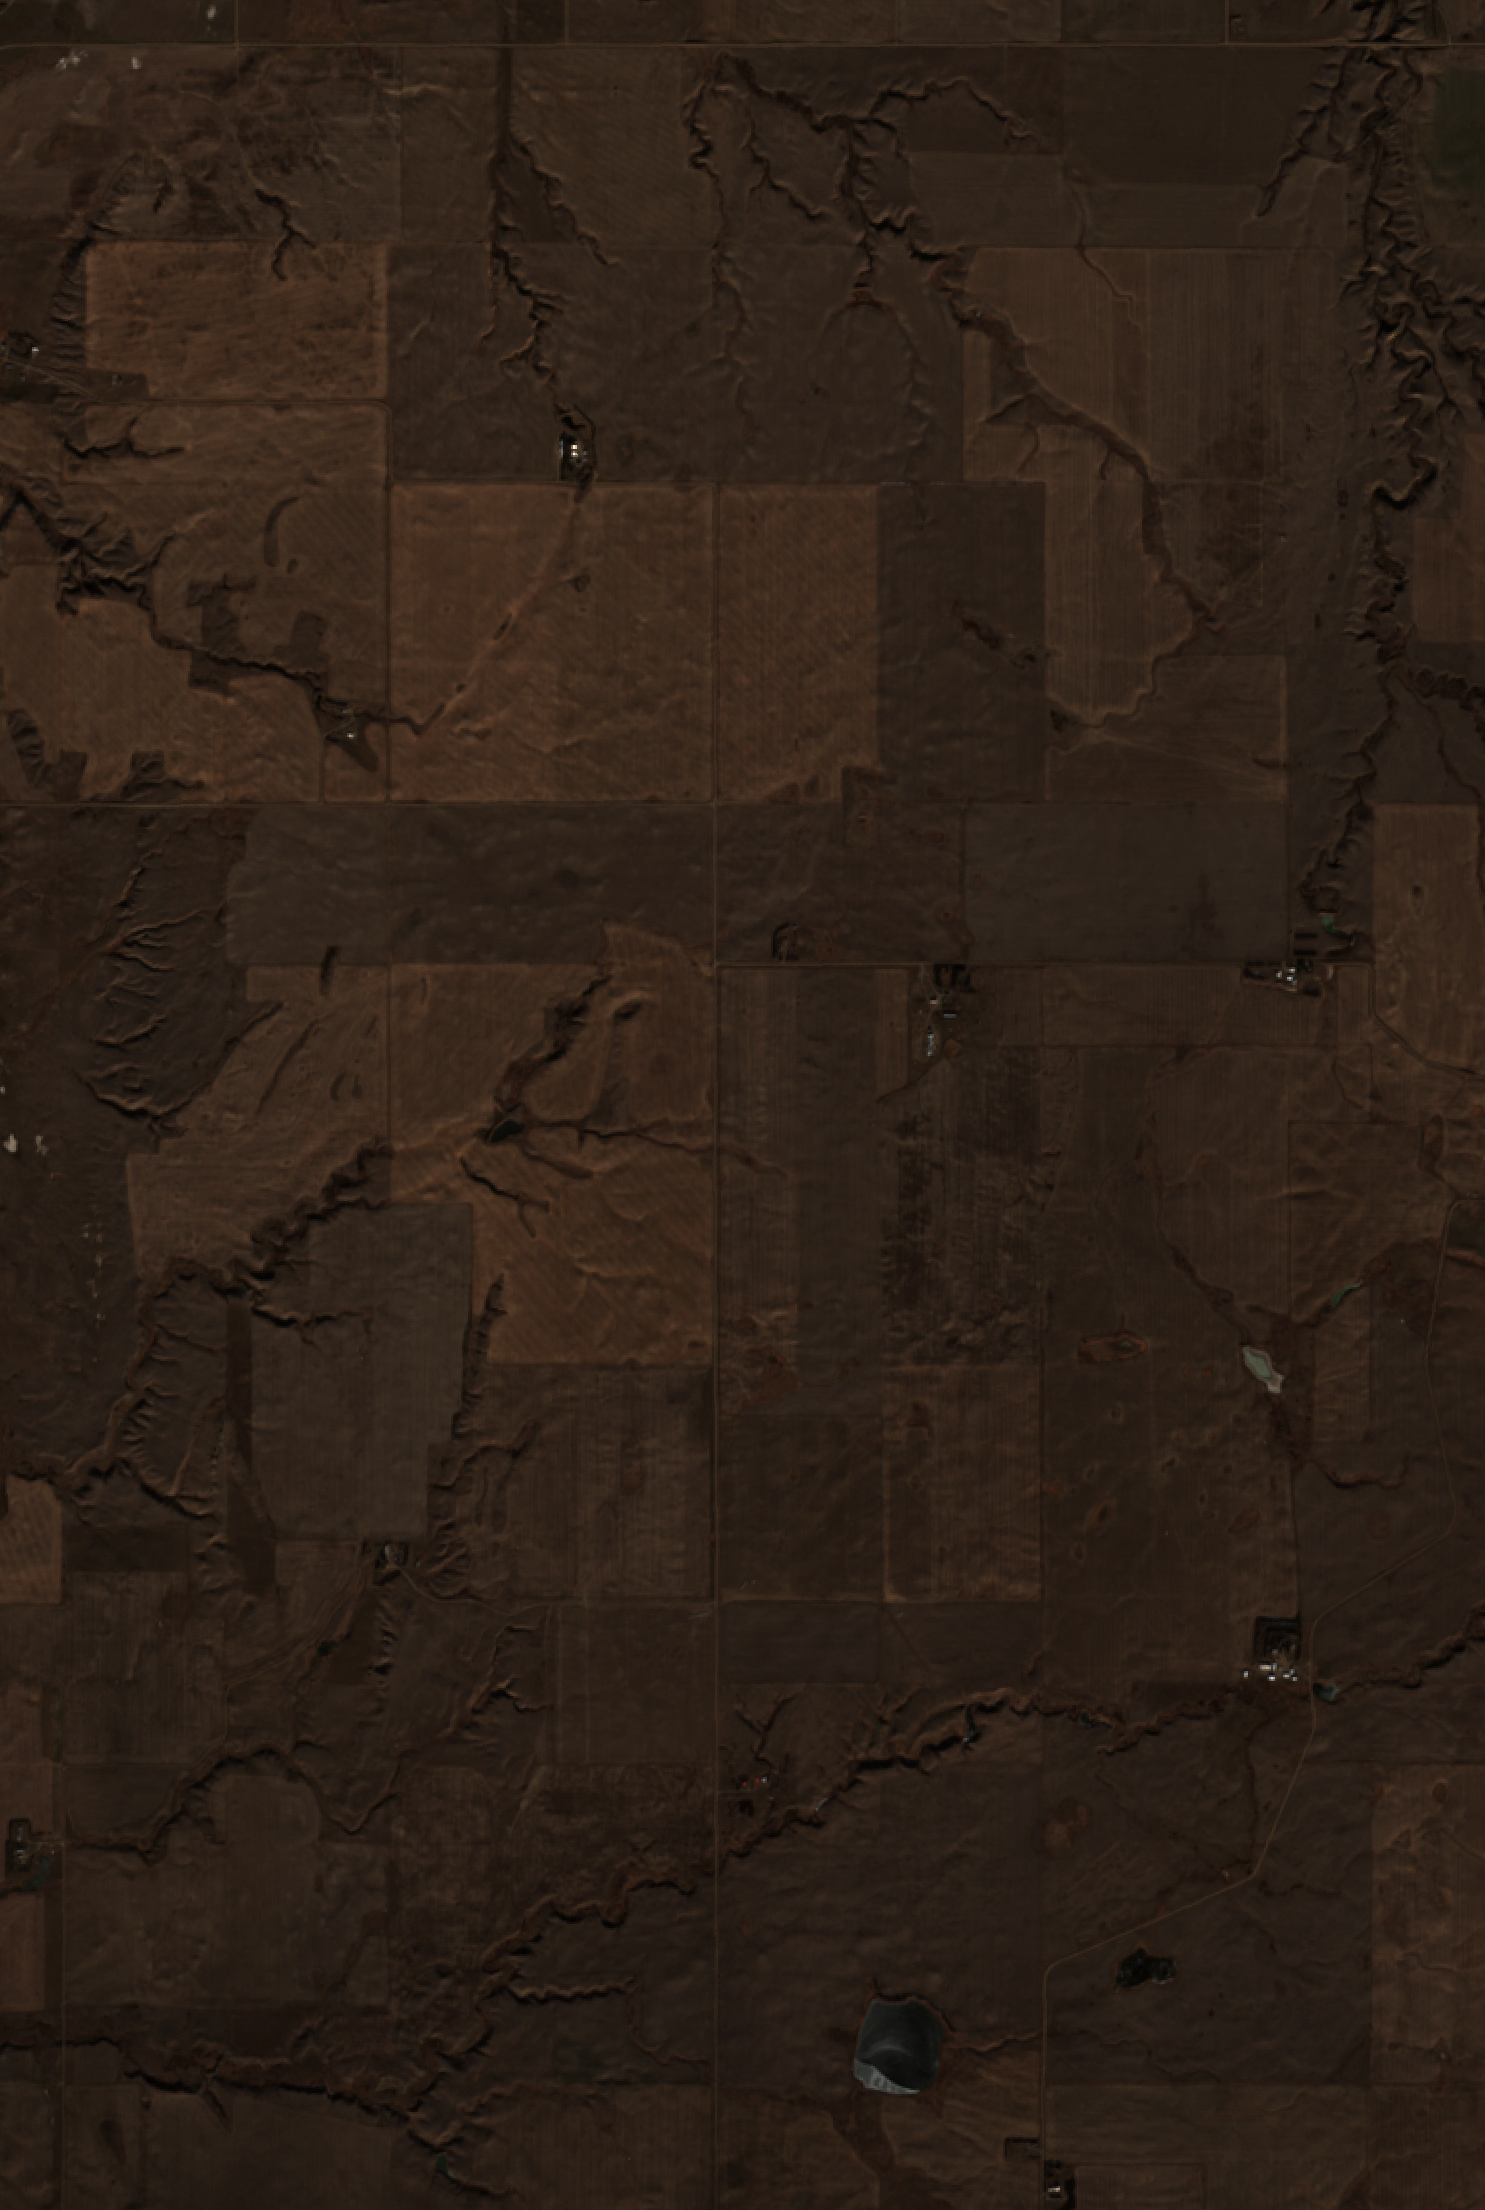

In [90]:
farm_map

In [123]:
evalscript_ndvi = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B02",
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 4
    }
  }
}
  

function evaluatePixel(sample) {
    let val = (sample.B08 - (sample.B04 - 0.106 * sample.B02)) / (sample.B08 + (sample.B04 - 0.106 * sample.B02));
    let imgVals = null;
    
    if (val < -0.5) imgVals = [0, 0, 0]; // Very low ARVI (black)
    else if (val < -0.2) imgVals = [0.5, 0.5, 0.5]; // Bare soil (gray)
    else if (val < 0.0) imgVals = [1, 0.8, 0.6]; // Sparse vegetation (light orange)
    else if (val < 0.2) imgVals = [1, 1, 0.4]; // Moderately sparse vegetation (yellow)
    else if (val < 0.4) imgVals = [0.6, 0.9, 0.3]; // Moderate vegetation (light green)
    else if (val < 0.6) imgVals = [0.3, 0.7, 0.2]; // Dense vegetation (green)
    else if (val < 0.8) imgVals = [0.1, 0.5, 0.1]; // Very dense vegetation (dark green)
    else imgVals = [0, 0.3, 0]; // Extremely dense vegetation (deep green)
    
    
    imgVals.push(sample.dataMask)
    
    return imgVals
}
"""

request_ndvi_img = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2024-11-09", "2024-11-29"),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

In [124]:
ndvi_img = request_ndvi_img.get_data()

In [115]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (2210, 1485, 3)


Image type: uint8


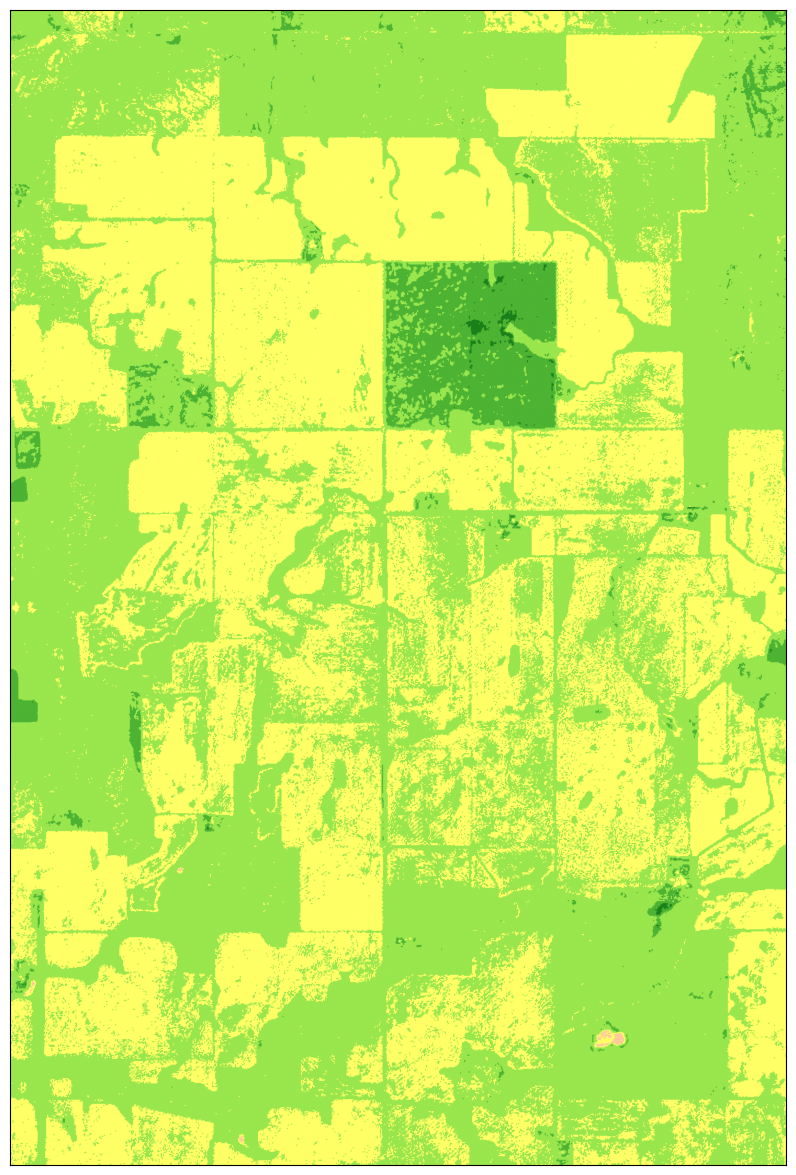

In [125]:
image = ndvi_img[0]
print(f"Image type: {image.dtype}")

# plot function
plot_image(image, factor=1 / 255)